In [1]:
import os
import scenic

### NuScenes Query
from scenic.simulators.carla.nusc_query_api import NuscQueryAPI
nusc = NuscQueryAPI(version='v1.0-trainval', \
                    dataroot='/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data')

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')


Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 39.949 seconds.
Reverse indexing ...
Done reverse indexing in 11.6 seconds.


In [2]:
import scenic
### Dependency Analysis
def cacheExprTreeNodes(attribute, nodeSet=None):
    """cache all the nodes of the input attribute's expression tree to the dictionary"""
    if nodeSet is None:
        nodeSet = set()
    nodeSet.add(attribute)
    if attribute._dependencies == ():
        return nodeSet
    for dep in attribute._dependencies:
        cacheExprTreeNodes(dep, nodeSet)
    return nodeSet

def cacheAttributes(scenario, attributeList):
    dictionary = {}
    dictionary['objAttributes_names'] = []
    dictionary['positionAttributes_names'] = []
    dictionary['headingAttributes_names'] = []
    
    # cache all object attributes
    for i in range(len(scenario.original_objects)):
        obj = scenario.original_objects[i]
        obj_name = 'obj'+str(i)
        dictionary[obj_name] = {}
        
        for attribute in attributeList:
            dictionary[obj_name][attribute] = {}
            dictionary[obj_name][attribute]['self'] = getattr(obj, attribute)
            dictionary[obj_name][attribute]['set'] = cacheExprTreeNodes(getattr(obj, attribute), None)
            dictionary[obj_name][attribute]['intermediate_variables_set'] = []
            dictionary[obj_name][attribute]['dependent_attribute_names'] = []
            dictionary[obj_name][attribute]['jointly_dependent_attribute_names'] = []
            dictionary[obj_name][attribute]['dependent_attributes_objs'] = set()
            dictionary[obj_name][attribute]['jointly_dependent_attributes_objs'] = set()
            dictionary['objAttributes_names'].append(obj_name+"_"+attribute)
            if attribute == 'position':
                dictionary['positionAttributes_names'].append(obj_name+"_"+attribute)
            if attribute == 'heading':
                dictionary['headingAttributes_names'].append(obj_name+"_"+attribute)
                
    return dictionary

def checkDependenceOnAnotherAttribute(intersection, attr1_name, attr2_name, dictionary):
    """ checks whether the two attr1 and attr2 are jointly dependent on an intermediate variable
    or is both dependent on another attribute. 
    Output:
    True, if attr1 and attr2 are "dependent" on another attribute, not intermediate variable
    False, attr1 and attr2 are both "jointly dependent" on an intermediate variable
    """
    [obj1_name, attr1] = attr1_name.split('_')
    attr1_obj = dictionary[obj1_name][attr1]['self']
    attr1_jointly_dep_attr_names = dictionary[obj1_name][attr1]['jointly_dependent_attribute_names']
    [obj2_name, attr2] = attr2_name.split('_')
    attr2_obj = dictionary[obj2_name][attr2]['self']
    attr2_jointly_dep_attr_names = dictionary[obj2_name][attr2]['jointly_dependent_attribute_names']
#     print("checkDependenceOnAnotherAttribute attr1_name: ", attr1_name)
#     print("checkDependenceOnAnotherAttribute attr2_name: ", attr2_name)
    original_intersection = intersection
    
    objAttributes_names = dictionary['objAttributes_names'] 
    for attr_name in objAttributes_names:
        if attr_name == attr1_name:
            continue
        elif attr_name == attr2_name:
            break
        else:
            [obj_name, attr] = attr_name.split('_')
            attr_obj = dictionary[obj_name][attr]['self']
            attr_depSet = dictionary[obj_name][attr]['dependent_attribute_names']
            
            if attr_obj in original_intersection and attr_name not in attr1_jointly_dep_attr_names \
                and attr_name not in attr2_jointly_dep_attr_names: 
#                 print("other attr_name in the intersection: ", attr_name)
                attr_cachedSet = dictionary[obj_name][attr]['set']
                original_intersection = original_intersection - attr_cachedSet
#                 print("len(original_intersection): ", len(original_intersection))
                if len(original_intersection) == 0:
#                     print("returns True")
                    # the intersection is another attribute
                    return True
    return False
        
def findAttribute(other_attr_obj, attr_dict, dictionary):
    for obj_attr in attr_dict['dependent_attribute_names']:
        [obj, attr] = obj_attr.split("_")
        if other_attr_obj is dictionary[obj][attr]['self']:
            return obj_attr
    return None

def checkIntermediateSetMembership(attr_obj, attrIntermediateList):
    for intermediateSet in attrIntermediateList:
        if attr_obj in intermediateSet:
            return True
    return False

def analysis(objAttributes_names, dictionary):
    for i in range(len(objAttributes_names)):
        for j in range(len(objAttributes_names)):
            if i < j:
                attr1_name = objAttributes_names[i]
                attr2_name = objAttributes_names[j]
                [obj_name1, attr1] = attr1_name.split('_')
                [obj_name2, attr2] = attr2_name.split('_')
        
                attribute1 = dictionary[obj_name1][attr1]
                attribute2 = dictionary[obj_name2][attr2]
                attr1_obj = attribute1['self']
                attr2_obj = attribute2['self']
                
                set1 = attribute1['set']
                set2 = attribute2['set']
                intersection = set1.intersection(set2)
                
                if attr1_obj in intersection and attr1_obj not in attribute2['dependent_attributes_objs']:
                    # attr2_obj is dependent on attr1_obj
                    attribute2['dependent_attribute_names'].append(attr1_name)
                    attribute2['dependent_attributes_objs'].add(attr1_obj)
                elif attr2_obj in intersection and attr2_obj not in attribute1['dependent_attributes_objs']:
                    # jointly_dependent case (e.g. depedendencyAnalysisTest4.scenic)
                    if attr2_name not in attribute1['jointly_dependent_attribute_names']:
                        attribute1['jointly_dependent_attribute_names'].append(attr2_name)
                        attribute1['jointly_dependent_attributes_objs'].add(attr2_obj)     
                        attribute1['intermediate_variables_set'].append(intersection)

                    if attr1_name not in attribute2['jointly_dependent_attribute_names']:
                        attribute2['jointly_dependent_attribute_names'].append(attr1_name)
                        attribute2['jointly_dependent_attributes_objs'].add(attr1_obj)
                        attribute2['intermediate_variables_set'].append(intersection)
                        
                elif len(intersection) > 0 \
                    and attr1_obj not in intersection and attr2_obj not in intersection \
                    and not checkDependenceOnAnotherAttribute(intersection, attr1_name, attr2_name, dictionary):
                    # the two attributes are jointly dependent (i.e. share intermediate variable(s))
                    if attr2_name not in attribute1['jointly_dependent_attribute_names']:
                        attribute1['jointly_dependent_attribute_names'].append(attr2_name)
                        attribute1['jointly_dependent_attributes_objs'].add(attr2_obj)     
                        attribute1['intermediate_variables_set'].append(intersection)
                    
                    if attr1_name not in attribute2['jointly_dependent_attribute_names']:
                        attribute2['jointly_dependent_attribute_names'].append(attr1_name)
                        attribute2['jointly_dependent_attributes_objs'].add(attr1_obj)
                        attribute2['intermediate_variables_set'].append(intersection)

                else:
                    pass
    return dictionary
    
def dependencyAnalysis(scenario, attributeList):
    dictionary = cacheAttributes(scenario, attributeList)
    dictionary['numberOfObjects'] = len(scenario.original_objects)
    objAttributes_names = dictionary['objAttributes_names']
    dictionary = analysis(objAttributes_names, dictionary)
    return dictionary

def sortDependency(dictionary, scenario, monolithic_translation=False):
    output = []
    covered_attributes = []
    
    if not monolithic_translation:
        for elem in dictionary['objAttributes_names']:
            if elem in covered_attributes:
                continue
            covered_attributes.append(elem)
            [obj_name, attr_name] = elem.split("_")
            joint_dep_set = dictionary[obj_name][attr_name]['jointly_dependent_attribute_names']
            if len(joint_dep_set) > 0:
                jointly_dependent_list = [elem]

                for j in joint_dep_set:
                    [j_obj_name, j_attr] = j.split("_")
                    if j not in covered_attributes:
                        jointly_dependent_list.append(j)
                        covered_attributes.append(j)
                output.append(jointly_dependent_list)
            else:
                output.append([elem])
    else:
        output = [(dictionary['objAttributes_names'])]
    return output

In [3]:
# ## Test Dependency Analysis

# attributeList = ['position', 'heading']
# d = dependencyAnalysis(scenario, attributeList)
# print(sortDependency(d, scenario))

In [18]:
### SMT Translation Pipeline

from scenic.core.regions import SectorRegion
from scenic.core.vectors import OrientedVector, Vector
from scenic.core.distributions import *
from scenic.domains.driving.roads import Network
from scenic.core.regions import PointInRegionDistribution
from scenic.core.type_support import TypecheckedDistribution
from scenic.core.geometry import normalizeAngle
import subprocess
import itertools
import numpy as np
import os

def resetConditionedVar(obj):
    obj._conditioned = obj
    if (obj._dependencies is None):
        return None
    for dep in obj._dependencies:
        resetConditionedVar(dep)
    return None

def unconditionAllAttributes(scenario):
    for obj in scenario.objects:
        resetConditionedVar(obj.position)
        resetConditionedVar(obj.heading)
        
def extractLabelAttribute(label, obj_index, attribute_name, objType, dataType, correspondence, egoObjIndex):
    # Extract specific attribute from a label generated from a scenic program
    
#     print("extractLabelAttribute()")
#     print("label[objType]: ", label[objType])
#     print("correspondence: ", correspondence)
#     print("correspondence[obj_index]: ", correspondence[obj_index])
#     print("attribute_name: ", attribute_name)
#     print("obj_index: ", obj_index)
#     print("egoObjIndex: ", egoObjIndex)
    output = None
    if obj_index != egoObjIndex:
        if obj_index > egoObjIndex:
            output = label[objType][correspondence[obj_index-1]][attribute_name]
    else:
        output = label['EgoCar'][attribute_name]

    assert(output is not None)
    if attribute_name == 'position':
        return Vector(output[0], output[1])
    if dataType == 'nuScenes':
        output = normalizeAngle(math.radians(output-90)) #90 deg to reorient to Scenic's global coordinate system
    return output
        
def initializeSMTFile(smt_file_path):
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')
    
def resetDictionary(cached_variables, smt_file_path):
    regionAroundEgo = cached_variables['regionAroundEgo']
    cached_variables.clear()
    cached_variables['variables'] = []
    cached_variables['regionAroundEgo'] = regionAroundEgo
    cached_variables['regionAroundEgo_polygon'] = regionAroundEgo.polygon
    cached_variables['smt_file_path'] = smt_file_path

def translateAttributeExpressionTree(attribute_name, attr_obj, attr_label, cached_variables, \
                                   dictionary, errorBound, debug=False):
    
    x_error_margin = str(errorBound['x'])
    y_error_margin = str(errorBound['y'])
    heading_error_margin = str(errorBound['heading'])
    
    ## TODO: add error bound range to attributes
    smt_file_path = cached_variables['smt_file_path']
    obj_name, attr_type = attribute_name.split("_")

    # Encode the given attribute's expression tree
    smt_var = attr_obj.encodeToSMT(smt_file_path, cached_variables, debug = debug)
    
    if attr_type == 'position':
        assert(isinstance(attr_label, Vector))
        x, y = smt_var
        (x_label, y_label) = (str(attr_label.x), str(attr_label.y))
        x_cond1 = smt_lessThanEq(smt_subtract(x_label, x_error_margin), x)
        x_cond2 = smt_lessThanEq(x, smt_add(x_label, x_error_margin))
        x_cond = smt_and(x_cond1, x_cond2)
        
        y_cond1 = smt_lessThanEq(smt_subtract(y_label, y_error_margin), y)
        y_cond2 = smt_lessThanEq(y, smt_add(y_label, y_error_margin))
        y_cond = smt_and(y_cond1, y_cond2)
        
#         (x_cond, y_cond) = vector_operation_smt((x_label, y_label), "equal",smt_var)
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(x_cond, y_cond)))
    else:
        heading_label = str(attr_label)
        heading_cond1 = smt_lessThanEq(smt_subtract(heading_label, heading_error_margin), smt_var)
        heading_cond2 = smt_lessThanEq(smt_var, smt_add(heading_label, heading_error_margin))
        writeSMTtoFile(smt_file_path, smt_assert(None, smt_and(heading_cond1, heading_cond2)))
#         writeSMTtoFile(smt_file_path, smt_assert(None, smt_equal(str(attr_label), smt_var)))
        
def findObjType(obj):
    if "Car" in str(obj) or "Truck" in str(obj) or "Motorcycle" in str(obj) or "Bicycle" in str(obj):
        return "Vehicles"
    elif "Pedestrian" in str(obj):
        return "Pedestrians"
    elif "Cone" in str(obj) or "Trash" in str(obj):
        return "Objects"
    else:
        raise NotImplementedError
    return None

def conditionAttributes(jointlyDependentAttributeList, dictionary, scenario, dataType, correspondence, \
                        egoObjIndex, label):
    for attribute_name in jointlyDependentAttributeList:
        obj_name, attr_name = attribute_name.split("_")
        obj_index = int(obj_name.split("obj")[1])
        objType = findObjType(scenario.original_objects[obj_index])
        attr_label = extractLabelAttribute(label, obj_index, attr_name, objType, dataType, correspondence, \
                                              egoObjIndex)
        attr_obj = dictionary[obj_name][attr_name]['self']
#         print("conditionAttributes attribute: ", attribute_name)
#         print("conditionAttributes attr_label: ", attr_label)
        if isinstance(attr_label, float) or isinstance(attr_label, int):
            attr_obj.conditionTo(Constant(attr_label))
        elif isinstance(attr_obj, PointInRegionDistribution):
            attr_obj.conditionTo(attr_label)
            if isinstance(attr_obj.region, TypecheckedDistribution): 
                attr_obj.region.dist.conditionTo(attr_label)
            else:
                attr_obj.region.conditionTo(attr_label)
        else:
            attr_obj.conditionTo(attr_label)

def validateLabelElement(scenario, label, cached_variables, jointlyDependentAttributeList, dictionary, \
                         correspondence, egoObjIndex, dataType, errorBound, debug=False, falseTesting=False,\
                        monolithic_translation=False):
    
    count = 0
    ## translate jointly dependent attribute expression trees
    for attribute_name in jointlyDependentAttributeList:
#         count += 1
#         if count >= 2:
#             break
        obj_name, attr_name = attribute_name.split("_")
        obj_index = int(obj_name.split("obj")[1])
        objType = findObjType(scenario.original_objects[obj_index])
        attr_label = extractLabelAttribute(label, obj_index, attr_name, objType, dataType, correspondence,\
                                          egoObjIndex)
#         print("validateLabelElement() attribute_name: ", attribute_name)
#         print("attr_label: ", attr_label)
        attr_obj = dictionary[obj_name][attr_name]['self']
        translateAttributeExpressionTree(attribute_name, attr_obj, attr_label, cached_variables, \
                                          dictionary, errorBound, debug)
#         print("validateLabelElement encoding done for validateLabelElement: ", attribute_name)
#         if monolithic_translation:
#             print("validLabelElement: Monolithic translation case -- condition attribute: ",attribute_name)
#             conditionAttributes([attribute_name], dictionary, scenario, dataType, correspondence, \
#                         egoObjIndex, label)
    
    smt_file_path = cached_variables['smt_file_path']
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if subprocess.call("./run_smt_encoding.sh") == 1:
        return True
        
    return False

def generateObjectMatchingCorrespondenceSet(scenario):
    objTypeOrder = []
    objTypeDict = {}
    
    for obj in scenario.original_objects:
        if obj is not scenario.egoObject:
            objType = findObjType(obj)
            
            objTypeOrder.append(objType)

            if objType not in objTypeDict.keys():
                objTypeDict[objType] = {}
                objTypeDict[objType]['count'] = 1
            else:
                objTypeDict[objType]['count'] += 1
    
#     print("objTypeOrder: ", objTypeOrder)
    
    total_permutation_number = 1
    for objType in objTypeDict.keys():
        count = objTypeDict[objType]['count']
        index_list = [i for i in range(count)]
        objTypeDict[objType]['correspondence'] = list(itertools.permutations(index_list))
        total_permutation_number *= len(objTypeDict[objType]['correspondence'])
    
#     print("total_permutation_number: ", total_permutation_number)
#     print("objTypeDict['Vehicles']['count']: ", objTypeDict['Vehicles']['count'])
#     print("objTypeDict['Vehicles']['correspondence']: ", objTypeDict['Vehicles']['correspondence'])
#     print("len(objTypeDict['Vehicles']['correspondence']): ", len(objTypeDict['Vehicles']['correspondence']))
#     print("objTypeDict['Pedestrians']['count']", objTypeDict['Pedestrians']['count'])
#     print("objTypeDict['Pedestrians']['correspondence']", objTypeDict['Pedestrians']['correspondence'])
#     print("objTypeDict['Objects']['count']", objTypeDict['Objects']['count'])
#     print("objTypeDict['Objects']['correspondence']", objTypeDict['Objects']['correspondence'])
    
    # sort the types by the number of counts
    types = list(objTypeDict.keys())
    counts = [objTypeDict[objType]['count'] for objType in types]
    sorted_types = []
    sorted_types_nums = []
    
    for i in range(len(types)):
        elem = max(counts)
        index = counts.index(max(counts))
        sorted_types.append(types[index])
        sorted_types_nums.append(elem)
        del types[index]
        del counts[index]
    
#     print("sorted_types: ", sorted_types)
#     print("sorted_types_nums: ", sorted_types_nums)
    
    if len(objTypeOrder)==0:
        return [(0,)]
    
    # compute the number of identical elements to insert per objType
    num_identicals = []
    for i in range(len(sorted_types)):
        if i == len(sorted_types)-1:
            num_identicals.append(1)
        else:
            num_identicals.append(np.prod(sorted_types_nums[i+1:]))
#     print("num_identicals: ", num_identicals)
    
    # create combinations of correspondences in the order of objTypeOrder
    correspondenceList = [[0]*len(objTypeOrder) for i in range(total_permutation_number)]
#     print("correspondenceList: ", correspondenceList)

    # Handling first objType
    objType = sorted_types[0]
    for j in range(len(objTypeDict[objType]['correspondence'])):
        correspondenceToEdit = correspondenceList[index]
#         print("correspondenceToEdit: ", correspondenceToEdit)
        objTypeCorrespondence = objTypeDict[objType]['correspondence'][j]
#         print("objTypeCorrespondence: ", objTypeCorrespondence)
        correspondence = createCorrespondence(correspondenceToEdit, objType, objTypeOrder, \
                                              objTypeCorrespondence)
#         print("correspondence: ", correspondence)

        for k in range(num_identicals[0]):
            correspondenceList[index] = correspondence
            index += 1
#     print("correspondenceList: ", correspondenceList)
#     print("len(correspondenceList): ", len(correspondenceList))
#     print("correspondenceList is Valid: ", len(correspondenceList)/num_identicals[0]==\
#           len(set([tuple(elem) for elem in correspondenceList])))
    
    # Handle the rest of objType
    for i in range(1,len(sorted_types)):
    # for each remaining object
        index = 0
        objType = sorted_types[i]
#         print("processing objType: ", objType)
        for j in range(len(objTypeDict[sorted_types[0]]['correspondence'])): 
        # loop for the number of first objType's correspondence
            for k in range(len(objTypeDict[objType]['correspondence'])):
            # loop for the number of distinct correspondences of remaining per obj
                correspondenceToEdit = correspondenceList[index]
#                 print("correspondenceToEdit: ", correspondenceToEdit)
                objTypeCorrespondence = objTypeDict[objType]['correspondence'][k]
#                 print("objTypeCorrespondence: ", objTypeCorrespondence)
                correspondence = createCorrespondence(correspondenceToEdit, objType, \
                                objTypeOrder, objTypeCorrespondence)
#                 print("correspondence: ", correspondence)
                for l in range(num_identicals[i]):
                    correspondenceList[index] = correspondence
                    index += 1
#                     print("index: ", index)
                
#                 print("kth loop completed: ", k)
#             print("jth full loop completed: ", j)

#     print("correspondenceList: ", correspondenceList)
    
    return correspondenceList



def createCorrespondence(correspondence, objType, objTypeOrder, objTypeCorrespondence):
    index = 0
    correspond_copy = correspondence.copy()
    for i in range(len(objTypeOrder)):
        if objTypeOrder[i] == objType:
            correspond_copy[i] = objTypeCorrespondence[index]
            index += 1
            if index == len(objTypeCorrespondence):
                break
    return correspond_copy
    

def findEgoObjIndex(scenario):
    for i in range(len(scenario.original_objects)):
        if scenario.original_objects[i] is scenario.egoObject:
            return i
    return None


In [19]:
# def generateObjectMatchingCorrespondenceSet(scenario, label=None, labelSource='carla'):
#     objTypeOrder = []
#     objTypeDict = {}
    
#     for obj in scenario.original_objects:
#         if obj is not scenario.egoObject:
#             objType = findObjType(obj)
            
#             objTypeOrder.append(objType)

#             if objType not in objTypeDict.keys():
#                 objTypeDict[objType] = {}
#                 objTypeDict[objType]['scenic_count'] = 1
#                 if labelSource == 'nuScenes':
#                     objTypeDict[objType]['label_count'] = len(label[objType])
#             else:
#                 objTypeDict[objType]['scenic_count'] += 1
    
# #     print("objTypeOrder: ", objTypeOrder)
    
#     total_permutation_number = 1
#     for objType in objTypeDict.keys():
#         count = objTypeDict[objType]['scenic_count']
#         index_list = [i for i in range(count)]
#         objTypeDict[objType]['correspondence'] = list(itertools.permutations(index_list))
#         total_permutation_number *= len(objTypeDict[objType]['correspondence'])
    
# #     print("total_permutation_number: ", total_permutation_number)
# #     print("objTypeDict['Vehicles']['count']: ", objTypeDict['Vehicles']['count'])
# #     print("objTypeDict['Vehicles']['correspondence']: ", objTypeDict['Vehicles']['correspondence'])
# #     print("len(objTypeDict['Vehicles']['correspondence']): ", len(objTypeDict['Vehicles']['correspondence']))
# #     print("objTypeDict['Pedestrians']['count']", objTypeDict['Pedestrians']['count'])
# #     print("objTypeDict['Pedestrians']['correspondence']", objTypeDict['Pedestrians']['correspondence'])
# #     print("objTypeDict['Objects']['count']", objTypeDict['Objects']['count'])
# #     print("objTypeDict['Objects']['correspondence']", objTypeDict['Objects']['correspondence'])
    
#     # sort the types by the number of counts
#     types = list(objTypeDict.keys())
#     counts = [objTypeDict[objType]['scenic_count'] for objType in types]
#     sorted_types = []
#     sorted_types_nums = []
    
#     for i in range(len(types)):
#         elem = max(counts)
#         index = counts.index(max(counts))
#         sorted_types.append(types[index])
#         sorted_types_nums.append(elem)
#         del types[index]
#         del counts[index]
    
# #     print("sorted_types: ", sorted_types)
# #     print("sorted_types_nums: ", sorted_types_nums)
    
#     if len(objTypeOrder)==0:
#         return [(0,)]
    
#     # compute the number of identical elements to insert per objType
#     num_identicals = []
#     for i in range(len(sorted_types)):
#         if i == len(sorted_types)-1:
#             num_identicals.append(1)
#         else:
#             num_identicals.append(np.prod(sorted_types_nums[i+1:]))
# #     print("num_identicals: ", num_identicals)
    
#     # create combinations of correspondences in the order of objTypeOrder
#     correspondenceList = [[0]*len(objTypeOrder) for i in range(total_permutation_number)]
# #     print("correspondenceList: ", correspondenceList)

#     # Handling first objType
#     objType = sorted_types[0]
#     for j in range(len(objTypeDict[objType]['correspondence'])):
#         correspondenceToEdit = correspondenceList[index]
# #         print("correspondenceToEdit: ", correspondenceToEdit)
#         objTypeCorrespondence = objTypeDict[objType]['correspondence'][j]
# #         print("objTypeCorrespondence: ", objTypeCorrespondence)
#         correspondence = createCorrespondence(correspondenceToEdit, objType, objTypeOrder, \
#                                               objTypeCorrespondence)
# #         print("correspondence: ", correspondence)

#         for k in range(num_identicals[0]):
#             correspondenceList[index] = correspondence
#             index += 1
# #     print("correspondenceList: ", correspondenceList)
# #     print("len(correspondenceList): ", len(correspondenceList))
# #     print("correspondenceList is Valid: ", len(correspondenceList)/num_identicals[0]==\
# #           len(set([tuple(elem) for elem in correspondenceList])))
    
#     # Handle the rest of objType
#     for i in range(1,len(sorted_types)):
#     # for each remaining object
#         index = 0
#         objType = sorted_types[i]
# #         print("processing objType: ", objType)
#         for j in range(len(objTypeDict[sorted_types[0]]['correspondence'])): 
#         # loop for the number of first objType's correspondence
#             for k in range(len(objTypeDict[objType]['correspondence'])):
#             # loop for the number of distinct correspondences of remaining per obj
#                 correspondenceToEdit = correspondenceList[index]
# #                 print("correspondenceToEdit: ", correspondenceToEdit)
#                 objTypeCorrespondence = objTypeDict[objType]['correspondence'][k]
# #                 print("objTypeCorrespondence: ", objTypeCorrespondence)
#                 correspondence = createCorrespondence(correspondenceToEdit, objType, \
#                                 objTypeOrder, objTypeCorrespondence)
# #                 print("correspondence: ", correspondence)
#                 for l in range(num_identicals[i]):
#                     correspondenceList[index] = correspondence
#                     index += 1
# #                     print("index: ", index)
                
# #                 print("kth loop completed: ", k)
# #             print("jth full loop completed: ", j)

# #     print("correspondenceList: ", correspondenceList)
    
#     return correspondenceList


In [20]:
# import scenic
# scenic_script = "./examples/carla/ICCV_Scenic_Experiments/8_agent_scenario.scenic"
# scenario = scenic.scenarioFromFile(scenic_script)
# x = generateObjectMatchingCorrespondenceSet(scenario)
# print("finalOutput: ", x)
# print(len(x))
# print(len(set([tuple(elem) for elem in x])))

In [21]:
x = [1,2,3]
y = x.copy()
y[0] = 5
print(x)
print(y)

[1, 2, 3]
[5, 2, 3]


In [23]:
### Object Matching
import math

def conditionAllAttributes(scenario, dictionary, label, attributeList, correspondence, egoObjIndex, dataType):
    for obj_index in range(len(scenario.original_objects)):
        obj = scenario.original_objects[obj_index]
        for attribute_name in attributeList:
            objType = findObjType(obj)
            attr_label = extractLabelAttribute(label, obj_index, attribute_name, objType, \
                                               dataType, correspondence, egoObjIndex)
            if isinstance(attr_label, (float, int)):
                attr_label = Constant(attr_label)
            obj_attr = getattr(obj, attribute_name)
            obj_attr.conditionTo(attr_label)

def satisfyHardConstraints(scenario, dictionary, label, attributeList, correspondence, egoObjIndex, dataType):
    unconditionAllAttributes(scenario)
    conditionAllAttributes(scenario, dictionary, label, attributeList, correspondence, egoObjIndex, dataType)
    return scenario.checkRequirements()

def scenarioObjClassCount(scenario):
    # check whether the number of objects match per class
    objClassCountDict = {}
    for obj in scenario.original_objects:
        objType = findObjType(obj)
        if obj is not scenario.egoObject:
            if objType not in objClassCountDict.keys():
                objClassCountDict[objType] = {}
                objClassCountDict[objType]['count'] = 1
            else:
                objClassCountDict[objType]['count'] += 1
        else:
            objClassCountDict['EgoCar'] = {}
            objClassCountDict['EgoCar']['count'] = 1
    return objClassCountDict

def checkLabelValidity(label, objClassCountDict):
    for objType in objClassCountDict.keys():
        if objType == 'EgoCar':
            continue
        if len(label[objType]) < objClassCountDict[objType]['count']:
            print("INVALID LABEL -- scenario vs label objects mismatch")
            print("Issue object type: ", objType)
            print("len(label[objType]): ", len(label[objType]))
            print("scenaro objectType's obj number: ", objTypeDict[objType]['count'])
            return False
    return True

def queryLabelSetup(scenario, smt_file_path='./test_smt_encoding.smt2', attributeList = ['position', 'heading'],\
                   dataType='carla', monolithic_translation=False):
    # Uncondition previously conditioned dependency objects
    unconditionAllAttributes(scenario)
    
    # setup basic info
    cached_variables = {}
    cached_variables['smt_file_path'] = smt_file_path
    cached_variables['variables'] = []
    egoObjIndex = findEgoObjIndex(scenario)
    objClassCountDict = scenarioObjClassCount(scenario)
    
    # Sort Attribute Dependency 
    dictionary = dependencyAnalysis(scenario, attributeList)
    sortedDependencyList = sortDependency(dictionary, scenario, monolithic_translation)
    
    # Compute All Correspondence
    allObjCorrespondence = generateObjectMatchingCorrespondenceSet(scenario)
    
    outputDict = {}
    outputDict['cached_variables'] = cached_variables
    outputDict['sortedDependencyList'] = sortedDependencyList
    outputDict['allObjCorrespondence'] = allObjCorrespondence
    outputDict['egoObjIndex'] = egoObjIndex
    outputDict['dictionary'] = dictionary
    outputDict['objClassCountDict'] = objClassCountDict
    outputDict['attributeList'] = attributeList
    return outputDict
    
def queryLabel(scenario, label, outputDict, errorBound, ego_visibleDistance = 30, ego_viewAngle = 135,\
               dataType='carla', smt_file_path='./test_smt_encoding.smt2', \
               debug=False, monolithic_translation = False):
    
    objClassCountDict = outputDict['objClassCountDict']
    print("objClassCountDict: ", objClassCountDict)
    if not checkLabelValidity(label, objClassCountDict):
        # number of objects do not match per class ==> reject the label
        print("INVALD LABEL! Obj Count does not match")
        return False
    
    # Unpack variables
    cached_variables = outputDict['cached_variables']
    sortedDependencyList = outputDict['sortedDependencyList']
    allObjCorrespondence = outputDict['allObjCorrespondence']
    print("allObjCorrespondence: ", allObjCorrespondence)
    egoObjIndex = outputDict['egoObjIndex']
    dictionary = outputDict['dictionary']
    attributeList = outputDict['attributeList']
    
    # Create Ego visible region
    (ego_x, ego_y) = label['EgoCar']['position']
    label_ego_pos = extractLabelAttribute(label, egoObjIndex, 'position', 'EgoCar', \
                                                  dataType, None, egoObjIndex)
    label_ego_heading = extractLabelAttribute(label, egoObjIndex, 'heading', 'EgoCar', \
                                                  dataType, None, egoObjIndex)
    regionAroundEgo = SectorRegion(label_ego_pos, ego_visibleDistance, label_ego_heading, \
                                    math.radians(ego_viewAngle))
    cached_variables['regionAroundEgo'] = regionAroundEgo
    cached_variables['regionAroundEgo_polygon'] = regionAroundEgo.polygon
    
    # Uncondition previously conditioned dependency objects
    unconditionAllAttributes(scenario)
    
#     print("begin query")
    for correspondence in allObjCorrespondence:        
        failed = False
#         print("queryLabel correspondence: ", correspondence)
        for jointlyDependentAttributeList in sortedDependencyList:
            # Initialize smt file, if exists
            initializeSMTFile(smt_file_path)
#             print(".........................validating : ", str(jointlyDependentAttributeList)+".......................")
            if validateLabelElement(scenario, label, cached_variables, jointlyDependentAttributeList, dictionary, \
                                            correspondence, egoObjIndex, dataType, errorBound, debug=debug, \
                                            monolithic_translation=monolithic_translation):
#                 print(".........................VALID ATTRIBUTE(S): ", str(jointlyDependentAttributeList)+".......................")
                conditionAttributes(jointlyDependentAttributeList, dictionary, scenario, dataType, \
                                    correspondence, egoObjIndex, label)
                resetDictionary(cached_variables, smt_file_path)
            else: # condition attributes in jointlyDependentAttributeList
                print("INVALD LABEL -- NON-VALID ATTRIBUTES: ", jointlyDependentAttributeList)
                failed = True
                unconditionAllAttributes(scenario)
                resetDictionary(cached_variables, smt_file_path)
                break
        
        ## Check Hard Constraint Satisfaction
        if not failed and satisfyHardConstraints(scenario, dictionary, label, attributeList, \
                                                 correspondence, egoObjIndex, dataType):
            return True
        if not failed:
            print("INVALD LABEL -- Hard Constraint Not Satisfied")

    return False

def convertScenicLabel(scenic_label):
    label = {}
    label['EgoCar'] = {}
    ego_pos = scenic_label.egoObject.position
    label['EgoCar']['position'] = (ego_pos[0], ego_pos[1])
    label['EgoCar']['heading'] = scenic_label.egoObject.heading
    label['Vehicles'] = []
    label['Pedestrians'] = []
    label['Objects'] = []
    for obj in scenic_label.objects:
        if obj is not scenic_label.egoObject:
            objType = findObjType(obj)
            objDict = {}
            objPos = obj.position
            objDict['position'] = (objPos[0], objPos[1])
            objDict['heading'] = obj.heading
            label[objType].append(objDict)
    return label

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


sortedDependencyList:  [['obj0_position'], ['obj0_heading'], ['obj1_position'], ['obj1_heading']]


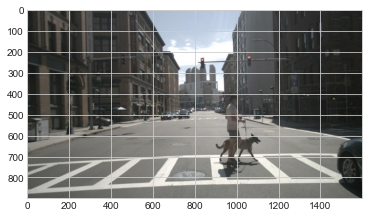

label:  {'EgoCar': {'heading': -40.752414186957324, 'position': (759.9239850726565, 1515.029304414374)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x2d36b72b0>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x2f31d7490>}], 'Pedestrians': [{'heading': 232.1640000006003, 'position': (765.892, 1508.719), 'box': <shapely.geometry.polygon.Polygon object at 0x2fe4fa3a0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x2f31d74f0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x2eb6df730>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x305ba2670>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  

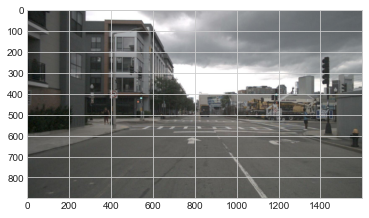

label:  {'EgoCar': {'heading': 138.1570617728848, 'position': (782.4627220019963, 410.4685902810983)}, 'Vehicles': [{'heading': 139.15452741447564, 'position': (725.753, 462.445), 'box': <shapely.geometry.polygon.Polygon object at 0x30643da90>}], 'Pedestrians': [{'heading': 221.95727939434258, 'position': (770.175, 433.694), 'box': <shapely.geometry.polygon.Polygon object at 0x30634c460>}, {'heading': 329.51790929923953, 'position': (755.982, 421.745), 'box': <shapely.geometry.polygon.Polygon object at 0x3062ce700>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x306304d90>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x2efdc4370>, 'time': '15:20', 'description': 'Parked cars, parking lot, parked trucks, container, peds, arrive at intersection, wait at intersection', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x305ba2940>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCo

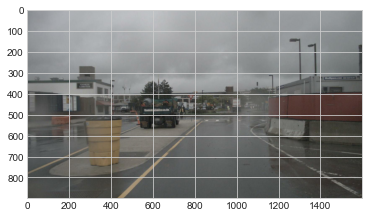

label:  {'EgoCar': {'heading': -32.559185726448916, 'position': (1736.711336168919, 1236.0473585795185)}, 'Vehicles': [{'heading': 326.43000000047385, 'position': (1757.018, 1226.625), 'box': <shapely.geometry.polygon.Polygon object at 0x305bce160>}, {'heading': 319.1774357940654, 'position': (1799.005, 1184.317), 'box': <shapely.geometry.polygon.Polygon object at 0x3060cbee0>}], 'Pedestrians': [{'heading': 154.22400000227663, 'position': (1771.02, 1217.83), 'box': <shapely.geometry.polygon.Polygon object at 0x305ff5640>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x305bce400>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x3059d2370>, 'time': '13:54', 'description': 'Rain, construction, turn right, roundabout', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x307489700>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-2018-09-18-13-

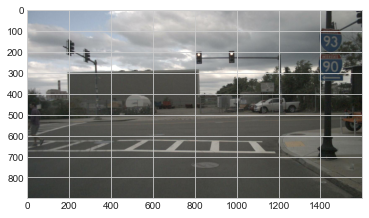

label:  {'EgoCar': {'heading': -41.213652339081, 'position': (802.4948963792922, 520.4605233831292)}, 'Vehicles': [{'heading': 50.39800000007182, 'position': (823.398, 489.345), 'box': <shapely.geometry.polygon.Polygon object at 0x3054e52e0>}, {'heading': 51.317999999904146, 'position': (826.749, 487.045), 'box': <shapely.geometry.polygon.Polygon object at 0x3057e2730>}], 'Pedestrians': [{'heading': 38.50200000000876, 'position': (816.88, 517.411), 'box': <shapely.geometry.polygon.Polygon object at 0x30534bc40>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3057e2700>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x305583c70>, 'time': '16:03', 'description': 'Parked truck, parked cars, pedestrian crossing', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x307489430>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
INVALD LABEL -- NON-VALID ATTRIBUTES:  

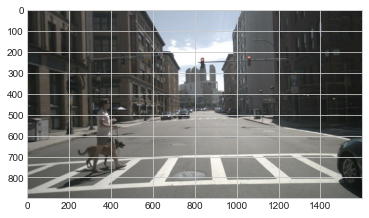

label:  {'EgoCar': {'heading': -40.75700599300784, 'position': (759.9248591135615, 1515.0303197785247)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x304ccff40>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x304ccff70>}], 'Pedestrians': [{'heading': 234.83066666726697, 'position': (767.856, 1511.37), 'box': <shapely.geometry.polygon.Polygon object at 0x3048eb8e0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3048eb940>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x304ff5c10>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x3080b09d0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  

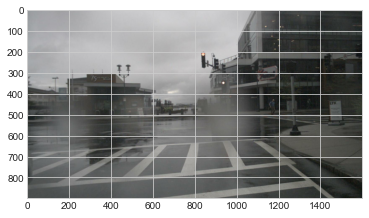

label:  {'EgoCar': {'heading': 50.23559468523621, 'position': (1539.3833505991622, 1318.5725015562487)}, 'Vehicles': [{'heading': 50.45700001716614, 'position': (1539.191, 1323.838), 'box': <shapely.geometry.polygon.Polygon object at 0x304746820>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.344, 1336.77), 'box': <shapely.geometry.polygon.Polygon object at 0x304746880>}, {'heading': 328.64513313195056, 'position': (1579.825, 1340.851), 'box': <shapely.geometry.polygon.Polygon object at 0x304746850>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x304746040>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x305082430>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30bab4040>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008

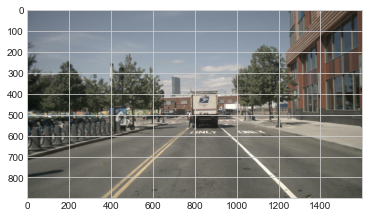

label:  {'EgoCar': {'heading': 157.35694888024713, 'position': (443.3116336845055, 819.4442727094751)}, 'Vehicles': [{'heading': 66.55500000133065, 'position': (418.366, 822.586), 'box': <shapely.geometry.polygon.Polygon object at 0x3054b8bb0>}, {'heading': 156.29600000023265, 'position': (415.976, 831.111), 'box': <shapely.geometry.polygon.Polygon object at 0x2fc5023d0>}], 'Pedestrians': [{'heading': 228.53800000004833, 'position': (420.784, 827.825), 'box': <shapely.geometry.polygon.Polygon object at 0x2fb0fe2e0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3042a8850>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x2fa080490>, 'time': '12:00', 'description': 'Cross intersection, bicyclist crossing, school bus, bicycle rack, jaywalker, peds, parked scooter', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30c0a3e50>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorresp

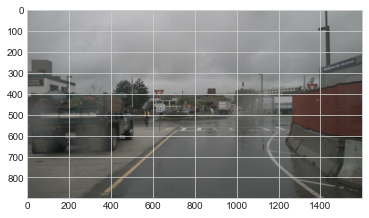

label:  {'EgoCar': {'heading': -36.88670794188227, 'position': (1744.0501005792717, 1230.8825313555858)}, 'Vehicles': [{'heading': 326.43000000047385, 'position': (1756.689, 1226.844), 'box': <shapely.geometry.polygon.Polygon object at 0x2fc502160>}, {'heading': 309.4300000004739, 'position': (1803.948, 1177.612), 'box': <shapely.geometry.polygon.Polygon object at 0x306335b50>}], 'Pedestrians': [{'heading': 154.22400000227663, 'position': (1769.223, 1218.884), 'box': <shapely.geometry.polygon.Polygon object at 0x3043db8e0>}], 'Objects': [], 'road': <shapely.geometry.multipolygon.MultiPolygon object at 0x2f1a1cc40>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x304447e50>, 'time': '13:54', 'description': 'Rain, construction, turn right, roundabout', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30c128550>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-20

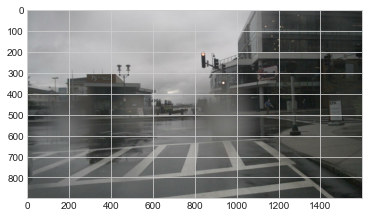

label:  {'EgoCar': {'heading': 50.231685400664674, 'position': (1539.3833426956426, 1318.572508944188)}, 'Vehicles': [{'heading': 50.45700001716614, 'position': (1539.192, 1323.839), 'box': <shapely.geometry.polygon.Polygon object at 0x309055ca0>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.461, 1337.454), 'box': <shapely.geometry.polygon.Polygon object at 0x309505730>}, {'heading': 326.7862268890941, 'position': (1579.059, 1341.222), 'box': <shapely.geometry.polygon.Polygon object at 0x3090469a0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3094f3430>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x309bb3eb0>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30d4fcd30>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008

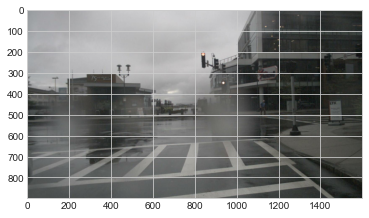

label:  {'EgoCar': {'heading': 50.23457584447821, 'position': (1539.383332237106, 1318.572515988137)}, 'Vehicles': [{'heading': 50.45700001716614, 'position': (1539.193, 1323.84), 'box': <shapely.geometry.polygon.Polygon object at 0x2fca60700>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.578, 1338.137), 'box': <shapely.geometry.polygon.Polygon object at 0x3085de370>}, {'heading': 324.92941940955313, 'position': (1578.307, 1341.616), 'box': <shapely.geometry.polygon.Polygon object at 0x3085ccdc0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x30845d820>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x30846c2b0>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30d55f4c0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-2

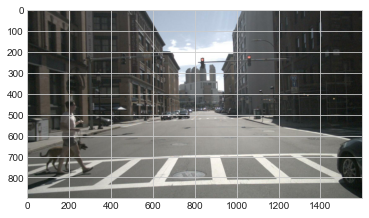

label:  {'EgoCar': {'heading': -40.75911044218081, 'position': (759.9251744035059, 1515.0306869498943)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x308212580>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x307d60700>}], 'Pedestrians': [{'heading': 240.16400000060025, 'position': (768.308, 1512.038), 'box': <shapely.geometry.polygon.Polygon object at 0x307d55640>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x307d556a0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x308243a30>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30e62c670>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence: 

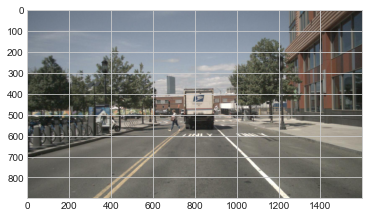

label:  {'EgoCar': {'heading': 156.2760218140156, 'position': (441.01508230170657, 820.4521958837511)}, 'Vehicles': [{'heading': 66.55500000133065, 'position': (418.386, 822.631), 'box': <shapely.geometry.polygon.Polygon object at 0x3078deee0>}, {'heading': 156.29600000023265, 'position': (415.915, 831.134), 'box': <shapely.geometry.polygon.Polygon object at 0x30842c550>}], 'Pedestrians': [{'heading': 230.53800000004824, 'position': (420.277, 827.239), 'box': <shapely.geometry.polygon.Polygon object at 0x3078e6c70>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3078e6cd0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x3078e6970>, 'time': '12:00', 'description': 'Cross intersection, bicyclist crossing, school bus, bicycle rack, jaywalker, peds, parked scooter', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30e807310>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorresp

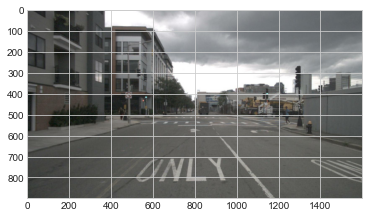

label:  {'EgoCar': {'heading': 137.65926152507083, 'position': (785.7486618372404, 407.4566852306004)}, 'Vehicles': [{'heading': 138.3540000018569, 'position': (732.047, 457.105), 'box': <shapely.geometry.polygon.Polygon object at 0x307923880>}], 'Pedestrians': [{'heading': 222.24371782756768, 'position': (770.425, 433.967), 'box': <shapely.geometry.polygon.Polygon object at 0x307aaa760>}, {'heading': 327.8500000005972, 'position': (755.066, 422.392), 'box': <shapely.geometry.polygon.Polygon object at 0x307570340>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x307a55730>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x307a40760>, 'time': '15:20', 'description': 'Parked cars, parking lot, parked trucks, container, peds, arrive at intersection, wait at intersection', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30e92d550>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCor

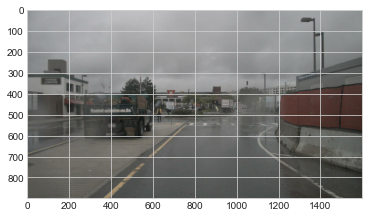

label:  {'EgoCar': {'heading': -35.69957178722766, 'position': (1741.7618962820939, 1232.574743511673)}, 'Vehicles': [{'heading': 326.43000000047385, 'position': (1756.799, 1226.771), 'box': <shapely.geometry.polygon.Polygon object at 0x30728f430>}, {'heading': 312.6790997657779, 'position': (1802.147, 1180.326), 'box': <shapely.geometry.polygon.Polygon object at 0x30729f640>}], 'Pedestrians': [{'heading': 154.22400000227663, 'position': (1769.822, 1218.533), 'box': <shapely.geometry.polygon.Polygon object at 0x30729fe50>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x30729fe20>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x30728fdc0>, 'time': '13:54', 'description': 'Rain, construction, turn right, roundabout', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30eb1d1f0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-2018-09-18-13

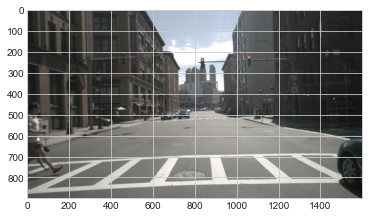

label:  {'EgoCar': {'heading': -40.76037599775625, 'position': (759.9255446942661, 1515.0311169441816)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x3083e0ac0>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x306e51040>}], 'Pedestrians': [{'heading': 241.66400000060025, 'position': (768.722, 1512.798), 'box': <shapely.geometry.polygon.Polygon object at 0x306de35e0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x306de3850>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x306dcff10>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30eaeb0d0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence: 

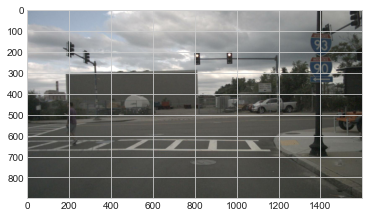

label:  {'EgoCar': {'heading': -41.5094567131817, 'position': (802.2599712606977, 520.6821905042405)}, 'Vehicles': [{'heading': 50.39800000007182, 'position': (823.423, 489.324), 'box': <shapely.geometry.polygon.Polygon object at 0x306527880>}, {'heading': 51.317999999904146, 'position': (826.749, 487.045), 'box': <shapely.geometry.polygon.Polygon object at 0x306559340>}], 'Pedestrians': [{'heading': 48.50200000000882, 'position': (815.988, 516.409), 'box': <shapely.geometry.polygon.Polygon object at 0x306534880>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3065590d0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x306600040>, 'time': '16:03', 'description': 'Parked truck, parked cars, pedestrian crossing', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x30e8d11f0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
INVALD LABEL -- NON-VALID ATTRIBUTES:

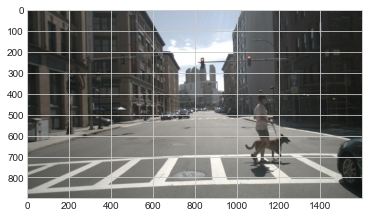

label:  {'EgoCar': {'heading': -40.75078285845404, 'position': (759.9238520578369, 1515.02914936668)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x306260130>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x30628a3d0>}], 'Pedestrians': [{'heading': 232.1640000006003, 'position': (765.371, 1508.056), 'box': <shapely.geometry.polygon.Polygon object at 0x3068ea250>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x30618e8b0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x3066c3910>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31117f430>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[

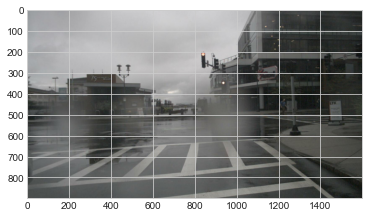

label:  {'EgoCar': {'heading': 50.23388064077993, 'position': (1539.3833636503118, 1318.5724902150828)}, 'Vehicles': [{'heading': 50.85713162006141, 'position': (1539.225, 1323.865), 'box': <shapely.geometry.polygon.Polygon object at 0x305c749d0>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.176, 1335.412), 'box': <shapely.geometry.polygon.Polygon object at 0x3072da070>}, {'heading': 328.50035709889266, 'position': (1581.351, 1340.145), 'box': <shapely.geometry.polygon.Polygon object at 0x305c5a640>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x305c6b760>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x30673c490>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x313b6f040>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n00

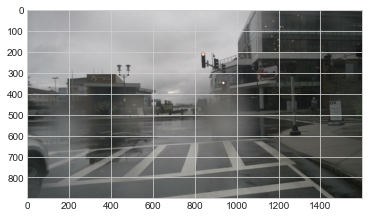

label:  {'EgoCar': {'heading': 50.24189900480789, 'position': (1539.383383023878, 1318.5724727858792)}, 'Vehicles': [{'heading': 50.97593261455569, 'position': (1539.469, 1324.148), 'box': <shapely.geometry.polygon.Polygon object at 0x3058ba640>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.025, 1332.017), 'box': <shapely.geometry.polygon.Polygon object at 0x3059035e0>}, {'heading': 320.5499852697107, 'position': (1584.878, 1338.018), 'box': <shapely.geometry.polygon.Polygon object at 0x3061a87c0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3066c3940>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x3058ba850>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x313b9ea60>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-

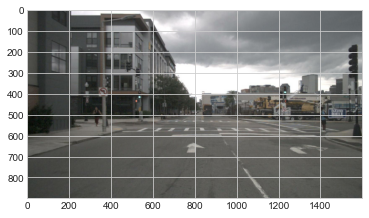

label:  {'EgoCar': {'heading': 138.94405688986504, 'position': (780.5095744202974, 412.203370748654)}, 'Vehicles': [{'heading': 139.55434201222351, 'position': (722.609, 465.111), 'box': <shapely.geometry.polygon.Polygon object at 0x3057cd400>}], 'Pedestrians': [{'heading': 221.81422087422916, 'position': (770.05, 433.557), 'box': <shapely.geometry.polygon.Polygon object at 0x305ac4670>}, {'heading': 330.3509282250189, 'position': (756.448, 421.434), 'box': <shapely.geometry.polygon.Polygon object at 0x30546b850>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x305786e50>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x30546b820>, 'time': '15:20', 'description': 'Parked cars, parking lot, parked trucks, container, peds, arrive at intersection, wait at intersection', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31479f4c0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorr

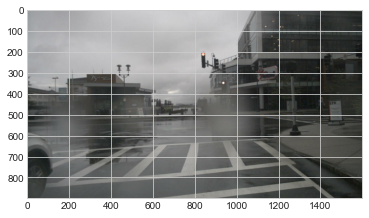

label:  {'EgoCar': {'heading': 50.23677979216646, 'position': (1539.3833855597811, 1318.5724707618292)}, 'Vehicles': [{'heading': 50.73566231219081, 'position': (1539.517, 1324.234), 'box': <shapely.geometry.polygon.Polygon object at 0x305051d90>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.075, 1331.339), 'box': <shapely.geometry.polygon.Polygon object at 0x305338730>}, {'heading': 319.57504666889537, 'position': (1585.542, 1337.55), 'box': <shapely.geometry.polygon.Polygon object at 0x305338520>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3053388e0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x305338ee0>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31228d5e0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008

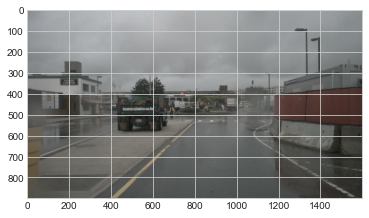

label:  {'EgoCar': {'heading': -34.115485333699134, 'position': (1739.289155776657, 1234.3217000688178)}, 'Vehicles': [{'heading': 326.43000000047385, 'position': (1756.909, 1226.698), 'box': <shapely.geometry.polygon.Polygon object at 0x30556a670>}, {'heading': 315.9284400269935, 'position': (1800.901, 1182.218), 'box': <shapely.geometry.polygon.Polygon object at 0x304e5c640>}], 'Pedestrians': [{'heading': 154.22400000227663, 'position': (1770.421, 1218.182), 'box': <shapely.geometry.polygon.Polygon object at 0x304d11c10>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x305829460>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x304eb2190>, 'time': '13:54', 'description': 'Rain, construction, turn right, roundabout', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31494b310>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-2018-09-18-1

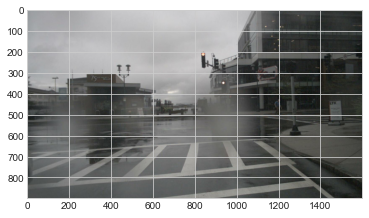

label:  {'EgoCar': {'heading': 50.23875659461006, 'position': (1539.383357072185, 1318.5724948032682)}, 'Vehicles': [{'heading': 50.65695641620687, 'position': (1539.208, 1323.852), 'box': <shapely.geometry.polygon.Polygon object at 0x304939100>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.26, 1336.091), 'box': <shapely.geometry.polygon.Polygon object at 0x304939130>}, {'heading': 330.5020000454969, 'position': (1580.601, 1340.507), 'box': <shapely.geometry.polygon.Polygon object at 0x304c0df40>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3049390d0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x304939f70>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x315ba1160>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-2

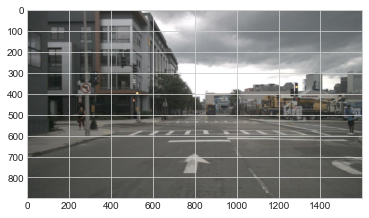

label:  {'EgoCar': {'heading': 139.641012410283, 'position': (778.1816467451113, 414.2266081956924)}, 'Vehicles': [{'heading': 139.95415181094847, 'position': (719.465, 467.778), 'box': <shapely.geometry.polygon.Polygon object at 0x3047da250>}], 'Pedestrians': [{'heading': 218.87181346035894, 'position': (770.049, 433.542), 'box': <shapely.geometry.polygon.Polygon object at 0x304424550>}, {'heading': 331.18393715197146, 'position': (756.917, 421.127), 'box': <shapely.geometry.polygon.Polygon object at 0x3044cbf10>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3041a8430>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x3041a8460>, 'time': '15:20', 'description': 'Parked cars, parking lot, parked trucks, container, peds, arrive at intersection, wait at intersection', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x3161993a0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCor

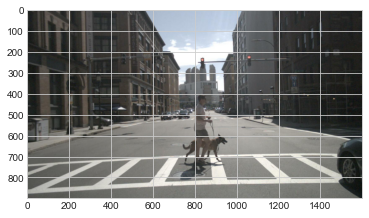

label:  {'EgoCar': {'heading': -40.757427058129714, 'position': (759.9241552584585, 1515.0295039939106)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x3040c7ca0>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x312a78250>}], 'Pedestrians': [{'heading': 232.1640000006003, 'position': (766.413, 1509.382), 'box': <shapely.geometry.polygon.Polygon object at 0x3040c79d0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3040c7cd0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x3040be9a0>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x3167c70d0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence: 

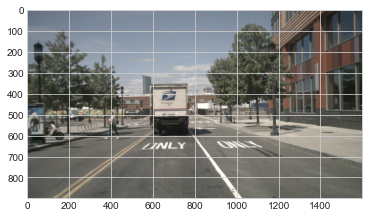

label:  {'EgoCar': {'heading': 151.24112575923658, 'position': (437.1870765640492, 822.3703554760142)}, 'Vehicles': [{'heading': 66.55500000133065, 'position': (418.381, 822.62), 'box': <shapely.geometry.polygon.Polygon object at 0x314f73be0>}, {'heading': 156.29600000023265, 'position': (416.048, 831.111), 'box': <shapely.geometry.polygon.Polygon object at 0x314f73340>}], 'Pedestrians': [{'heading': 234.03800000004824, 'position': (419.317, 825.965), 'box': <shapely.geometry.polygon.Polygon object at 0x314f732b0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x314f73280>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x314f73cd0>, 'time': '12:00', 'description': 'Cross intersection, bicyclist crossing, school bus, bicycle rack, jaywalker, peds, parked scooter', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x3167cb430>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespo

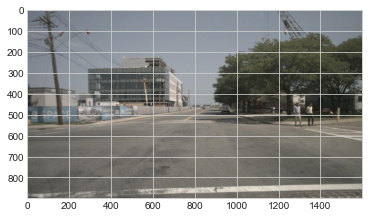

label:  {'EgoCar': {'heading': 59.697592680047855, 'position': (2136.104139338075, 903.5642915283773)}, 'Vehicles': [{'heading': 54.86500000003679, 'position': (2173.804, 957.006), 'box': <shapely.geometry.polygon.Polygon object at 0x30414c190>}], 'Pedestrians': [{'heading': 251.43874316558666, 'position': (2152.928, 918.351), 'box': <shapely.geometry.polygon.Polygon object at 0x305051d60>}, {'heading': 246.9780000001189, 'position': (2153.684, 917.904), 'box': <shapely.geometry.polygon.Polygon object at 0x30414c1c0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x315000fd0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x304513f40>, 'time': '11:52', 'description': 'Wait at intersection, peds crossing crosswalk, scooter, turn left, heavy truck, bus stop', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x3167cfd30>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence

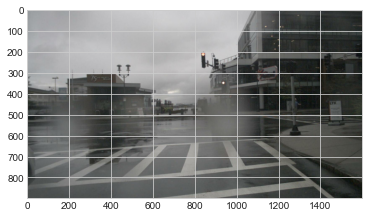

label:  {'EgoCar': {'heading': 50.22999854327498, 'position': (1539.3833742598129, 1318.5724829501935)}, 'Vehicles': [{'heading': 51.25705001826611, 'position': (1539.259, 1323.892), 'box': <shapely.geometry.polygon.Polygon object at 0x315015b80>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.008, 1334.055), 'box': <shapely.geometry.polygon.Polygon object at 0x315005880>}, {'heading': 324.5013910652888, 'position': (1582.808, 1339.346), 'box': <shapely.geometry.polygon.Polygon object at 0x304c1e6d0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x31500f580>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x315000460>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x314fa1670>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008

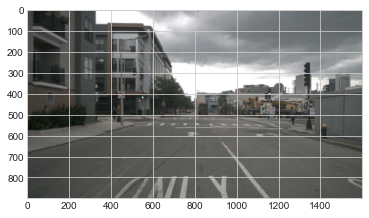

label:  {'EgoCar': {'heading': 137.60918960817838, 'position': (784.264119781719, 408.8246242577395)}, 'Vehicles': [{'heading': 138.71401310318942, 'position': (729.217, 459.507), 'box': <shapely.geometry.polygon.Polygon object at 0x3041972e0>}], 'Pedestrians': [{'heading': 222.11490076638935, 'position': (770.313, 433.844), 'box': <shapely.geometry.polygon.Polygon object at 0x316f4af70>}, {'heading': 328.60009198980384, 'position': (755.476, 422.099), 'box': <shapely.geometry.polygon.Polygon object at 0x315005e50>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x314f1bfd0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x314efa760>, 'time': '15:20', 'description': 'Parked cars, parking lot, parked trucks, container, peds, arrive at intersection, wait at intersection', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x316f410d0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCo

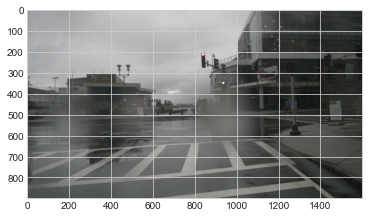

label:  {'EgoCar': {'heading': 50.22996319079629, 'position': (1539.3833694579694, 1318.5724864379408)}, 'Vehicles': [{'heading': 51.05708601905815, 'position': (1539.242, 1323.878), 'box': <shapely.geometry.polygon.Polygon object at 0x316ee23d0>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1564.092, 1334.733), 'box': <shapely.geometry.polygon.Polygon object at 0x316ee2160>}, {'heading': 326.5009220805308, 'position': (1582.086, 1339.758), 'box': <shapely.geometry.polygon.Polygon object at 0x316ee2310>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x316ee25e0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x316ee22e0>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x316e11310>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008

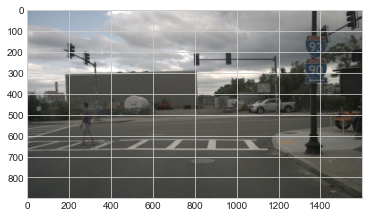

label:  {'EgoCar': {'heading': -41.665382754026005, 'position': (802.092266085167, 520.8336418433419)}, 'Vehicles': [{'heading': 50.39800000007182, 'position': (823.433, 489.315), 'box': <shapely.geometry.polygon.Polygon object at 0x317ae1430>}, {'heading': 51.317999999904146, 'position': (826.749, 487.045), 'box': <shapely.geometry.polygon.Polygon object at 0x316ee80a0>}], 'Pedestrians': [{'heading': 44.50200000000882, 'position': (815.638, 515.907), 'box': <shapely.geometry.polygon.Polygon object at 0x316ee3790>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x316ee3b50>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x317abcfd0>, 'time': '16:03', 'description': 'Parked truck, parked cars, pedestrian crossing', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x316ede0d0>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
INVALD LABEL -- NON-VALID ATTRIBUTES

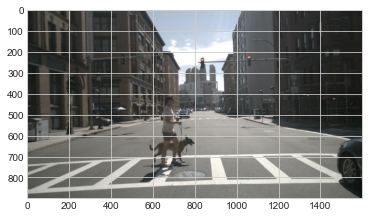

label:  {'EgoCar': {'heading': -40.75886460153708, 'position': (759.924355087416, 1515.0297354262475)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x318882100>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x318882310>}], 'Pedestrians': [{'heading': 232.1640000006003, 'position': (766.935, 1510.045), 'box': <shapely.geometry.polygon.Polygon object at 0x318882220>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3188820d0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x318882640>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x3188b4280>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [

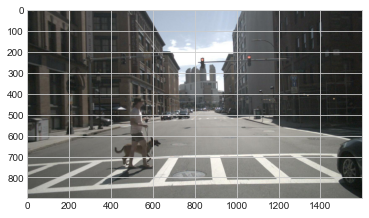

label:  {'EgoCar': {'heading': -40.75458217010288, 'position': (759.9245883976064, 1515.0300050067874)}, 'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x317befd30>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x317befd60>}], 'Pedestrians': [{'heading': 233.49733333393365, 'position': (767.395, 1510.707), 'box': <shapely.geometry.polygon.Polygon object at 0x317ae1be0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x3188ab880>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x318851130>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31887e040>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence: 

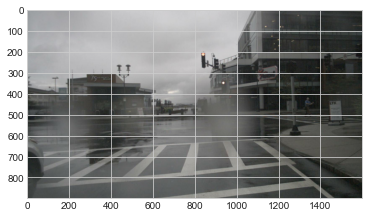

label:  {'EgoCar': {'heading': 50.23759970203258, 'position': (1539.3833804419053, 1318.572475603618)}, 'Vehicles': [{'heading': 51.21647785158092, 'position': (1539.387, 1324.039), 'box': <shapely.geometry.polygon.Polygon object at 0x31a6c0190>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1563.975, 1332.697), 'box': <shapely.geometry.polygon.Polygon object at 0x31a6c0610>}, {'heading': 321.526039465797, 'position': (1584.2, 1338.469), 'box': <shapely.geometry.polygon.Polygon object at 0x31a6c05e0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x31a6c0b80>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x31a6c0550>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31a123e50>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n008-201

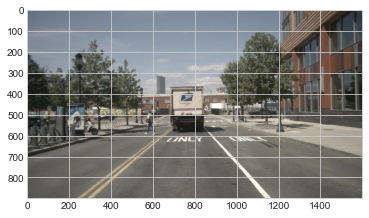

label:  {'EgoCar': {'heading': 154.1907295419629, 'position': (439.151691376542, 821.3329400150953)}, 'Vehicles': [{'heading': 66.55500000133065, 'position': (418.383, 822.625), 'box': <shapely.geometry.polygon.Polygon object at 0x31accb910>}, {'heading': 156.29600000023265, 'position': (416.034, 831.079), 'box': <shapely.geometry.polygon.Polygon object at 0x31a6d23a0>}], 'Pedestrians': [{'heading': 232.5380000000482, 'position': (419.791, 826.635), 'box': <shapely.geometry.polygon.Polygon object at 0x31a126520>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x318851310>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x312a78370>, 'time': '12:00', 'description': 'Cross intersection, bicyclist crossing, school bus, bicycle rack, jaywalker, peds, parked scooter', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x317be8700>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespond

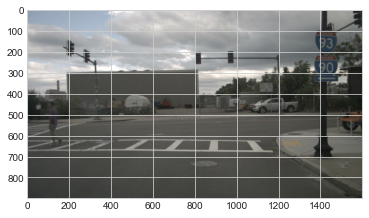

label:  {'EgoCar': {'heading': -41.37515415815779, 'position': (802.4016554233976, 520.5497652639302)}, 'Vehicles': [{'heading': 50.39800000007182, 'position': (823.41, 489.334), 'box': <shapely.geometry.polygon.Polygon object at 0x31a1263a0>}, {'heading': 51.317999999904146, 'position': (826.749, 487.045), 'box': <shapely.geometry.polygon.Polygon object at 0x317b111c0>}], 'Pedestrians': [{'heading': 38.50200000000876, 'position': (816.589, 516.916), 'box': <shapely.geometry.polygon.Polygon object at 0x31acec1f0>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x317b11d60>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x317b043a0>, 'time': '16:03', 'description': 'Parked truck, parked cars, pedestrian crossing', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31a123e50>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
INVALD LABEL -- NON-VALID ATTRIBUTES:

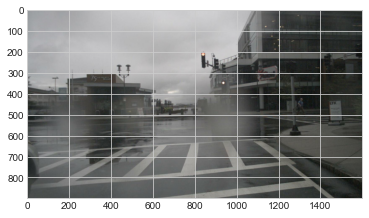

label:  {'EgoCar': {'heading': 50.233793979428135, 'position': (1539.3833778037078, 1318.572479288598)}, 'Vehicles': [{'heading': 51.45700001716614, 'position': (1539.321, 1323.949), 'box': <shapely.geometry.polygon.Polygon object at 0x317af97c0>}], 'Pedestrians': [{'heading': 265.4550000051965, 'position': (1563.924, 1333.376), 'box': <shapely.geometry.polygon.Polygon object at 0x317b04df0>}, {'heading': 322.50200004549697, 'position': (1583.515, 1338.908), 'box': <shapely.geometry.polygon.Polygon object at 0x317b09460>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x31b3760d0>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x317ad5a60>, 'time': '15:32', 'description': 'Rain, Wait at intersection, trucks, cars, peds on sidewalk', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x31b3a7430>}
objClassCountDict:  {'EgoCar': {'count': 1}, 'Pedestrians': {'count': 1}}
allObjCorrespondence:  [[0]]
LABEL VALID:  n00

In [24]:
import matplotlib.image as mpimg

def nuScenesExperiment(scenario, dataset_directory_path):
    outputDict = queryLabelSetup(scenario,  smt_file_path='./test_smt_encoding.smt2', \
                                 attributeList = ['position', 'heading'],dataType = 'nuScenes')
    errorBound = {}
    errorBound['x'] = 0.25 # meters == radius of the error margin ball around x
    errorBound['y'] = 0.25 # meters == radius of the error margin ball around y
    errorBound['heading'] = 0.0872 # radians = 5 degrees
    print("sortedDependencyList: ", outputDict['sortedDependencyList'])
    
    filenames = [file for file in os.listdir(dataset_directory_path) if file.endswith('.jpg')]
    count = 0
    valid_files = []
    for file in filenames:
        img = mpimg.imread(os.path.join(dataset_directory_path, file))
        plt.imshow(img)
        plt.show()
        unconditionAllAttributes(scenario)
        label = nusc.get_img_data(file)
        print("label: ", label)
        if not queryLabel(scenario, label, outputDict, errorBound, ego_visibleDistance = 50, ego_viewAngle = 135,\
                          dataType='nuScenes', debug=False):
            print("LABEL NOT VALID: ", file)
        else:
            print("LABEL VALID: ", file)
            valid_files.append(file)
#         break
#     print("len(valid_files) == len(filenames): ", len(valid_files) == len(filenames))
    return valid_files

directory = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data/experiment_results'
subject1 = 'experiment_result_JayShenoy'
subject2 = 'experiment_result_TaeSung'
subject3 = 'experiment_result_Xiangyu'
scenario_list = ['scenario1','scenario2','scenario3','scenario4','scenario5']
dataset_directory_path = os.path.join(directory, 'scenario1_queried')
scenic_script_path = "./examples/carla/ICCV_Human_Experiments/experiment1.scenic"
scenario = scenic.scenarioFromFile(scenic_script_path)
valid_files = nuScenesExperiment(scenario, dataset_directory_path)

In [15]:
scenario.original_objects[1].heading._conditioned.value

2.481229877815696

In [ ]:
label:  {'EgoCar': {'heading': -40.752414186957324, 'position': (759.9239850726565, 1515.029304414374)}, 
         'Vehicles': [{'heading': 318.96000000001504, 'position': (761.545, 1508.955), 'box': <shapely.geometry.polygon.Polygon object at 0x2f2f75dc0>}, {'heading': 230.93899999997697, 'position': (793.527, 1503.259), 'box': <shapely.geometry.polygon.Polygon object at 0x2f0e09310>}], 
         'Pedestrians': [{'heading': 232.1640000006003, 'position': (765.892, 1508.719), 'box': <shapely.geometry.polygon.Polygon object at 0x2f2fb3b20>}], 'Objects': [], 'road': <shapely.geometry.polygon.Polygon object at 0x2f0e09340>, 'sidewalk': <shapely.geometry.multipolygon.MultiPolygon object at 0x2fa101c10>, 'time': '11:28', 'description': 'Arrive at intersection, ped loading car trunk, ped with dog crossing crosswalk, bus', 'traffic_flow': <function NuscQueryAPI.get_img_data.<locals>.get_traffic_flow at 0x2f820bb80>}


In [ ]:
from scenic.core.geometry import normalizeAngle
from scenic.core.vectors import Vector
from nuscenes.map_expansion.map_api import NuScenesMap

dataroot = '/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data'
map_api = NuScenesMap(dataroot=dataroot, map_name='boston-seaport')

def get_traffic_flow(point):
    lane_token = map_api.record_on_point(point.x, point.y, 'lane')

    if lane_token == '':
        return 0

    lane_rec = map_api.get('lane', lane_token)

    from_edge = map_api.get('line', lane_rec['from_edge_line_token'])
    to_edge = map_api.get('line', lane_rec['to_edge_line_token'])

    from_nodes = [map_api.get('node', t) for t in from_edge['node_tokens']]
    from_nodes = [np.array([n['x'], n['y']]) for n in from_nodes]
    to_nodes = [map_api.get('node', t) for t in to_edge['node_tokens']]
    to_nodes = [np.array([n['x'], n['y']]) for n in to_nodes]

    # Compute traffic flow vector using midpoints of edges
    from_mid = (from_nodes[0] + from_nodes[1]) / 2
    to_mid = (to_nodes[0] + to_nodes[1]) / 2
    traffic_flow_vec = to_mid - from_mid

    heading = np.arctan2(traffic_flow_vec[1], traffic_flow_vec[0])
    output = normalizeAngle(heading - (np.pi /2))
    return output

point = Vector(759.9239850726565, 1515.029304414374)
print(math.degrees(get_traffic_flow(point)))

In [ ]:
import scenic

def scenicExperiment(scenic_script_path, num_test = 10):
    scenario = scenic.scenarioFromFile(scenic_script)
    monolithic_translation = False
    outputDict = queryLabelSetup(scenario,  smt_file_path='./test_smt_encoding.smt2', \
                                 attributeList = ['position', 'heading'],dataType = 'carla',\
                                 monolithic_translation=monolithic_translation)
    errorBound = {}
    errorBound['x'] = 0.25 # meters == radius of the error margin ball around x
    errorBound['y'] = 0.25 # meters == radius of the error margin ball around y
    errorBound['heading'] = 0.0872 # radians = 5 degrees
    print("sortedDependencyList: ", outputDict['sortedDependencyList'])
    
    for i in range(num_test):
        unconditionAllAttributes(scenario)
        print(".......... sampling a new scene from the scenic program ..........")
        scenic_label, _ = scenario.generateForQuery(maxIterations=10000)
        label = convertScenicLabel(scenic_label)
        print("sampled label: ", label)
        if not queryLabel(scenario, label, outputDict, errorBound, dataType='carla', debug=False, monolithic_translation=monolithic_translation):
            print("LABEL NOT VALID: ", label)
        else:
            print("LABEL VALID")

scenic_script = "./examples/carla/ICCV_Scenic_Experiments/5_agent_scenario.scenic"
scenicExperiment(scenic_script, num_test=3)

In [ ]:
# ### NuScenes Query
# import scenic
# from scenic.simulators.carla.nusc_query_api import NuscQueryAPI
# nusc = NuscQueryAPI(version='v1.0-trainval', \
#                     dataroot='/Users/edwardkim/Desktop/Scenic_Query/nuscenes_data')

In [ ]:
# import os
# import scenic
# scenic_script = "./examples/carla/ICCV_Human_Experiments/experiment1.scenic"
# scenario = scenic.scenarioFromFile(scenic_script)
# # map_path = '/Users/edwardkim/Desktop/Scenic_Query/Scenic/tests/formats/opendrive/maps/CARLA/Town05.xodr'

# for i in range(1):
#     unconditionAllAttributes(scenario)
#     sample = scenario.generateForQuery(maxIterations = 4000, verbosity=0)
#     label, _ = sample
#     if not validateLabel(scenario, label, dataType='nuScenes', debug=False):
#         print("NOT VALID LABEL")
#         break
#     else:
#         print("label is valid: ", i)


In [ ]:
"""
Issue1: ahead/behind, left/right of uses the same heading angle as the referenced
        (1) As a result, position & heading are jointly dependent
        ==> what if we do not allow joint dependency between position and heading?
        This assumes that we can decouple joint dependency between the two, if exists.
        Is this true? Yes
        ==> Limitation: if many there are many jointly dependent features all at once, it may not be feasible to solve
        
        (2) an obj can have its position be dependent on its heading because its heading is the same as the 
        heading of another object to which the obj is depedent
        ==> is this only an issue with ego? because the ordering of the objects 
        ==> ==> solution: just keep the original objects ordering

Issue2: my assumption that jointly dependent and dependent relationships are disjoint is wrong
        (e.g. dependencyAnalysisTest4.scenic)
        ==> it's not possible to capture such case since the attribute contains the intermediate variable
        ==> another ordering process needs to be done within jointly dependent features based on dependence relations

Issue3: Need to check the case when multiple attributes are dependent on another attributes
        (e.g. )
        

Sorting Approach
Since the objects are listed in the order the scenario is written, 
the order in which SMT translation is to be done stays intact
The only issue now is to determine joint dependency
==> before adding to joint dependency, check whether the jointly dependent attribute is dependent on any of the
other jointly dependent attributes
"""